# GRU Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import random
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("scripts")
from scripts.steam_review_dataset import SteamReviewDataset
from scripts.annotations import update_df_review_labels


In [3]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [5]:
# Lade die Daten
df = pd.read_csv("../data/reviews_100k_cleaned_new.csv.bz2")

# Lade labels
with open("./scripts/results/results-v2-2025-02-03T19_58_54.749839-nall-llama3.2.json", "r") as fi:
    labels = json.load(fi)

labels = {int(k):v for k,v in labels.items()} # str keys to int

print(df.head(n=5))


   review_id                                             review  voted_up  \
0          0  hogwarts legacy be a pretty decent open world ...      True   
1          1  we demand an update to fix the crash issue mys...     False   
2          2  overall i enjoy it but some downside choice do...      True   
3          3  i enjoy the game but definitely would not say ...      True   
4          4  b a beautiful yet shallow dive into the wizard...      True   

   votes_up  weighted_vote_score  app_id  
0       374             0.948440  990080  
1       722             0.928115  990080  
2       335             0.922237  990080  
3       213             0.920985  990080  
4       184             0.911110  990080  


In [6]:
# One hot encode labels
# see https://discuss.pytorch.org/t/multi-label-classification-in-pytorch/905/44


df = update_df_review_labels(df, labels)
df = df.dropna() # 94079 -> 218 rows

print(df.loc[:, "gamemode":"bugs"])

print(df.loc[:, "gamemode":"bugs"].sum())

mapping 12 unique labels: online_play, support, gamemode, visuals, gameplay, sound, seasonal_content, price, hardware_requirements, story, updates, bugs
       gamemode  visuals  gameplay  sound  seasonal_content  price  \
214         0.0      0.0       0.0    0.0               0.0    0.0   
719         0.0      0.0       0.0    0.0               0.0    0.0   
978         0.0      0.0       1.0    1.0               0.0    0.0   
2832        1.0      0.0       1.0    0.0               0.0    0.0   
3342        0.0      0.0       0.0    0.0               0.0    0.0   
...         ...      ...       ...    ...               ...    ...   
89571       0.0      0.0       0.0    0.0               0.0    0.0   
89576       0.0      1.0       1.0    1.0               0.0    0.0   
89638       1.0      0.0       0.0    0.0               0.0    0.0   
90213       0.0      0.0       0.0    0.0               0.0    0.0   
90231       0.0      0.0       0.0    0.0               0.0    0.0   

      

In [7]:
print(df)

       review_id                                             review  voted_up  \
214          218  game be good but since the last patch a few da...     False   
719          738  pro game be absolutely one of the prettiest ga...      True   
978         1001  i would not recommend if you just want to play...     False   
2832        2891  c go be an absolute classic that continue to s...      True   
3342        3419  c remain an endure classic in the realm of com...      True   
...          ...                                                ...       ...   
89571      93817  brilliant fulfilling game you can do load with...      True   
89576      93822  get it day ago and it be a very fun game it be...      True   
89638      93887  a lot of basic feature break or do not wont th...     False   
90213      94474  realy a monday morning game when change anythi...     False   
90231      94493  the only question people ask me when i say i b...      True   

       votes_up  weighted_v

In [8]:
# Aufteilen in Train+Validation und Test (80/20 Split)
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42 # TODO stratify causes issues with multilabel targets
)

# Aufteilen von Train+Validation in Training und Validation (75/25 von Train+Val)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.25, random_state=42
)

# Überprüfe die Größe der Splits
print(f"Original size: {len(df)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Original size: 218
Train size: 130
Validation size: 44
Test size: 44


In [9]:
# Erstelle Dataset-Objekte
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
max_len = 200  # 91% der Reviews haben weniger als 200 Tokens
batch_size = 32

train_dataset = SteamReviewDataset(data=train_df, tokenizer=tokenizer, max_len=max_len, topic_mode=True)
val_dataset = SteamReviewDataset(data=val_df, tokenizer=tokenizer, max_len=max_len, topic_mode=True)
test_dataset = SteamReviewDataset(data=test_df, tokenizer=tokenizer, max_len=max_len, topic_mode=True)

# Erstelle DataLoader für jeden Split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Batch Shape
for tokens, labels in train_loader:
    print(f"Tokens shape: {tokens.shape}, Labels shape: {labels.shape}")
    break

Tokens shape: torch.Size([32, 200]), Labels shape: torch.Size([32, 10])


In [10]:
print(train_dataset[5])

(tensor([ 324,   40,    4,    8,   18,   98,    5,  191,  659,   22,   92,   21,
          39,    4,  237,   16,  310,  454,  829,    6,   53,   31, 1004,   11,
          87,  182,   17,    7,  890,  385,   48,    9,  668, 1640,  194,   76,
           9,  215, 2078,   21,    4,  334,  228, 1450,   12,    4,    8,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  

In [11]:
class GRUClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        gru_layers: int,
        hidden_dim: int,
        dropout: float,
        output_dim: int,
        pad_idx: int,
    ):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_idx
        )
        self.gru = nn.GRU(
            input_size=embedding_dim,
            num_layers=gru_layers,
            hidden_size=hidden_dim,
            dropout=dropout if gru_layers > 1 else 0,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)

        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)

        last_hidden_state = gru_out[:, -1, :]  # (batch_size, hidden_dim)

        output = self.fc(last_hidden_state)  # (batch_size, output_dim)

        return output

In [12]:
def train_model(
    model: GRUClassifier,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    lr: float,
    device=torch.device("cpu"),
):
    # Loss und Optimizer definieren
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4, fused=False)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=1
    )

    model.to(device)

    print(f"Start training on device '{device}'")

    # Early Stopping Parameter
    patience = 3
    patience_counter = 0
    best_val_accuracy = 0.0
    best_model_state = None
    last_epoch = 0

    # Listen für Visualisierung
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training und Validation Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_labels = []
        train_preds = []

        train_progress = tqdm(
            train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", ncols=100
        )

        epoch_start_time = time.time()  # Startzeit für die Epoche

        # Trainingsloop
        for batch in train_progress:
            tokens, labels = batch
            # print(f"tokens = {tokens}, labels = {labels}")
            tokens, labels = tokens.to(device), labels.to(device)

            # Forward Pass
            optimizer.zero_grad()
            outputs = model(tokens)
            loss = criterion(outputs.squeeze(), labels)

            # Backward Pass und Optimierung
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            # Berechne Predictions und füge sie zur Liste hinzu
            train_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
            train_labels += labels.cpu().numpy().tolist()

            # Update TQDM mit dem aktuellen Loss
            train_progress.set_postfix(
                loss=f"{running_loss / (train_progress.n + 1):.3f}"
            )

        # Berechne Trainings-Accuracy
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validierung
        model.eval()
        val_loss = 0.0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for batch in val_loader:
                tokens, labels = batch
                tokens, labels = tokens.to(device), labels.to(device)

                outputs = model(tokens)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                val_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
                val_labels += labels.cpu().numpy().tolist()

        scheduler.step(val_loss)  # Scheduler mit Validierungs-Loss aufrufen

        # Berechne Validierungs-Accuracy
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        mins, secs = divmod(epoch_duration, 60)

        print(
            "├ "
            f"Train Loss: {running_loss/len(train_loader):.4f}, "
            f"Train Accuracy: {train_accuracy:.4f}, "
            f"Validation Loss: {val_loss/len(val_loader):.4f}, "
            f"Validation Accuracy: {val_accuracy:.4f}, "
            f"Time: {int(mins):2}:{secs:.2f}m"
        )

        # Early Stopping Überprüfung
        if val_accuracy > best_val_accuracy:
            print(
                f"└ Validation accuracy improved: {best_val_accuracy:.4f} → {val_accuracy:.4f}"
            )
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict()  # Speichere das beste Modell
            last_epoch = epoch
        else:
            patience_counter += 1
            print(
                f"└ No improvement in validation accuracy. "
                f"Patience counter: {patience_counter}/{patience}. Using LR: {scheduler.get_last_lr()[0]:.1e}",
            )
            # Überprüfe, ob Early Stopping ausgelöst werden soll
            if patience_counter >= patience:
                print(
                    "Early stopping triggered! "
                    f"Best Validation Accuracy: {best_val_accuracy:.2f}, on epoch {last_epoch+1}"
                )
                break

    # Lade das beste Modell zurück, falls Early Stopping ausgelöst wurde
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(
        f"Finished Training: Best Validation Accuracy: {best_val_accuracy:.2f}, on epoch {last_epoch+1}"
    )

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [17]:
# Lade den Tokenizer, um `vocab_size` und `pad_id` zu erhalten
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
vocab_size = tokenizer.get_piece_size()
pad_idx = tokenizer.pad_id()

# Modellparameter
embedding_dim = 512
gru_layers = 2
hidden_dim = 1024
output_dim = 10
dropout = 0.5

# Initialisiere das GRU-Modell
model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    gru_layers=gru_layers,
    hidden_dim=hidden_dim,
    dropout=dropout,
    output_dim=output_dim,
    pad_idx=pad_idx,
)
print(model)

GRUClassifier(
  (embedding): Embedding(4000, 512, padding_idx=0)
  (gru): GRU(512, 1024, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)


In [18]:
# Trainiere das Modell
epochs = 100
lr = 0.001

trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    device=device,
)

Start training on device 'cuda'


Epoch [1/100]: 100%|██████████████████████████████████████| 5/5 [00:00<00:00,  5.17it/s, loss=0.422]


├ Train Loss: 0.4219, Train Accuracy: 0.4231, Validation Loss: 0.4342, Validation Accuracy: 0.1818, Time:  0:1.10m
└ Validation accuracy improved: 0.0000 → 0.1818


Epoch [2/100]: 100%|██████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s, loss=0.353]


├ Train Loss: 0.3529, Train Accuracy: 0.3462, Validation Loss: 0.4249, Validation Accuracy: 0.2955, Time:  0:0.86m
└ Validation accuracy improved: 0.1818 → 0.2955


Epoch [3/100]: 100%|██████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s, loss=0.252]


├ Train Loss: 0.2520, Train Accuracy: 0.4231, Validation Loss: 0.3763, Validation Accuracy: 0.2955, Time:  0:0.84m
└ No improvement in validation accuracy. Patience counter: 1/3. Using LR: 1.0e-03


Epoch [4/100]: 100%|██████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s, loss=0.293]


├ Train Loss: 0.2932, Train Accuracy: 0.4231, Validation Loss: 0.3538, Validation Accuracy: 0.2955, Time:  0:0.85m
└ No improvement in validation accuracy. Patience counter: 2/3. Using LR: 1.0e-03


Epoch [5/100]: 100%|██████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s, loss=0.326]


├ Train Loss: 0.3264, Train Accuracy: 0.4538, Validation Loss: 0.3544, Validation Accuracy: 0.2727, Time:  0:0.84m
└ No improvement in validation accuracy. Patience counter: 3/3. Using LR: 1.0e-03
Early stopping triggered! Best Validation Accuracy: 0.30, on epoch 2
Finished Training: Best Validation Accuracy: 0.30, on epoch 2


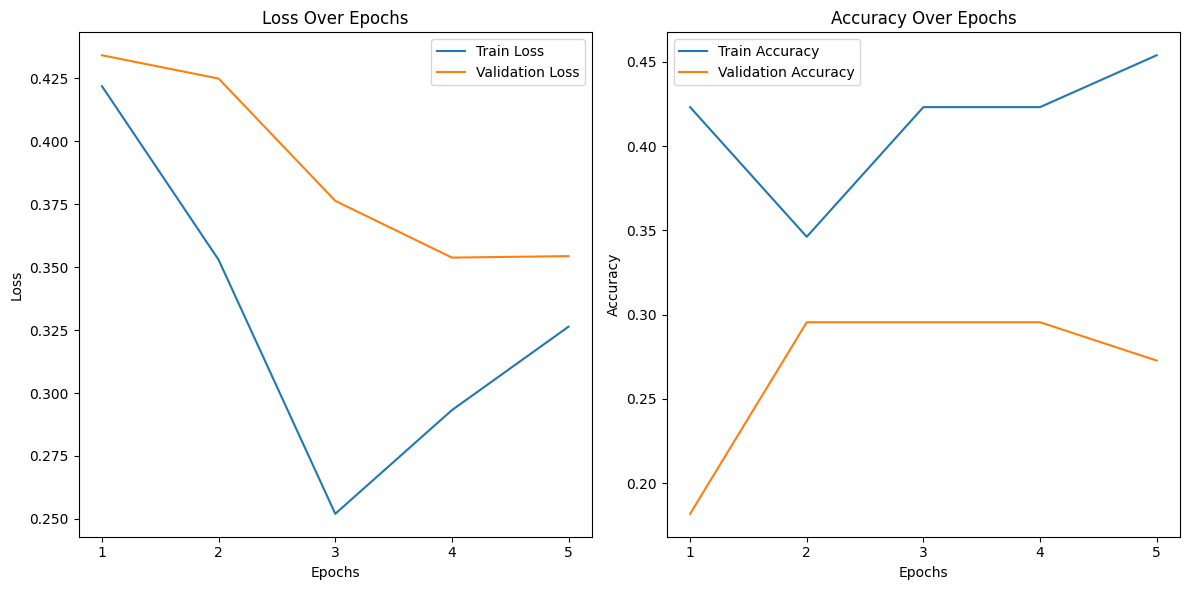

In [19]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xticks(range(1, len(epochs) + 1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xticks(range(1, len(epochs) + 1))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    # Anzeigen
    plt.tight_layout()
    plt.show()


plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# Funktion zum Testen des Modells mit zusätzlichen Metriken
def evaluate_model(model, test_loader):
    model.eval()  # Setze das Modell in den Eval-Modus
    test_loss = 0.0
    test_labels = []
    test_preds = []

    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():  # Keine Gradientenberechnung für Test
        for batch in test_loader:
            tokens, labels = batch
            tokens, labels = tokens.to(device), labels.to(device)

            # Forward Pass
            outputs = model(tokens)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            # Berechne Vorhersagen und füge sie zur Liste hinzu
            test_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
            test_labels += labels.cpu().numpy().tolist()

    # Berechne Metriken
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds)
    test_recall = recall_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)

    # Ausgabe der Metriken
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    return test_labels, test_preds


# Teste das Modell
test_labels, test_preds = evaluate_model(model, test_loader)

In [ ]:
def plot_confusion_matrix(y_true, y_pred):

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        confusion_matrix(y_true, y_pred),
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


plot_confusion_matrix(test_labels, test_preds)

### Results

**Hardware Specs:**
- CPU: AMD Ryzen 7 3700X 8-Core
- GPU: Nvidia GeForce RTX 3060 Ti
- RAM: 48GB
- OS: Linux Mint 22.1

**Training Results**

| Device | GRULayers | Dropout | EmbeddingDim | HiddenDim | VocabSize |     LR | Epoch | time/Epoch | TestAcc    | TestF1     |
| ------ | --------: | ------: | -----------: | --------: | --------: | -----: | ----: | ---------- | ---------- | ---------- |
| CPU    |         1 |       0 |          128 |       256 |     8.000 |  0.001 |     5 | 03:41      | ?          | ?          |
| Cuda   |         1 |       0 |          128 |       128 |     4.000 |  0.001 |     5 | 00:20      | 0.9096     | 0.9337     |
| Cuda   |         1 |       0 |          128 |       256 |     4.000 |  0.001 |     4 | 00:28      | **0.9110** | **0.9347** |
| Cuda   |         1 |       0 |          128 |       256 |     8.000 |  0.001 |    13 | 00:28      | 0.9019     | 0.9273     |
| Cuda   |         1 |       0 |          128 |       512 |     4.000 |  0.001 |    12 | 00:37      | 0.9013     | 0.9271     |
| Cuda   |         1 |       0 |          256 |       256 |     8.000 |  0.001 |    10 | 00:28      | 0.9051     | 0.9296     |
| Cuda   |         1 |       0 |          512 |       256 |     4.000 |  0.001 |    10 | 00:29      | 0.8897     | 0.9175     |
| Cuda   |         1 |       0 |          512 |       256 |    17.000 |  0.001 |     5 | 00:29      | 0.8781     | 0.9063     |
| Cuda   |         1 |       0 |          512 |       256 |    17.000 | 0.0001 |     5 | 00:29      | 0.8929     | 0.9190     |
| Cuda   |         1 |       0 |          512 |      1024 |     4.000 |  0.001 |     8 | 01:17      | 0.9022     | 0.9275     |
| Cuda   |         2 |     0.3 |          128 |       256 |     4.000 |  0.001 |     9 | 00:37      | 0.8875     | 0.9151     |
| Cuda   |         2 |     0.3 |          128 |       512 |     4.000 |  0.001 |     9 | 00:55      | 0.8915     | 0.9210     |
| Cuda   |         2 |     0.3 |          256 |       512 |     4.000 |  0.001 |    10 | 00:56      | 0.8992     | 0.9260     |
| Cuda   |         2 |     0.5 |          256 |      1024 |     4.000 |  0.001 |     4 | 02:13      | 0.8542     | 0.8855     |
| Cuda   |         2 |     0.5 |          512 |      1024 |     4.000 |  0.001 |     7 | 02:18      | 0.9103     | 0.9340     |